# Лінійна регресія

У цьому домашньому завданні ми працюємо з набором даних про рівень щастя у країнах за 2019 рік. Він доступний в кабінеті або можна завантажити з Kaggle [змагання](https://www.kaggle.com/unsdsn/world-happiness?select=2019.csv).

Усі імпорти розміщуємо зверху, під цією секцією.

In [12]:
import pandas as pd
import seaborn as sns
import missingno as msno
import numpy as np
import functools
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline


print(f"pandas: {pd.__version__}")
print(f"seaborn: {sns.__version__}")
print(f"missingno: {msno.__version__}")
print(f"numpy: {np.__version__}")


pandas: 1.5.3
seaborn: 0.12.2
missingno: 0.5.2
numpy: 1.22.4


1. Зчитайте дані за допомогою pandas у змінну `df`.

In [13]:
url = 'https://raw.githubusercontent.com/dmytrovelychko/rd_ds_python/main/datasets/hw_4/2019.csv'
df = pd.read_csv(url)

Initial analysis:

In [14]:
print(f"shape: {df.shape}")
df[:5]

shape: (156, 9)


,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,1,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393
1,2,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410
2,3,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341
3,4,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118
4,5,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298


In [15]:
df.dtypes

Overall rank                      int64
Country or region                object
Score                           float64
GDP per capita                  float64
Social support                  float64
Healthy life expectancy         float64
Freedom to make life choices    float64
Generosity                      float64
Perceptions of corruption       float64
dtype: object

<Axes: >

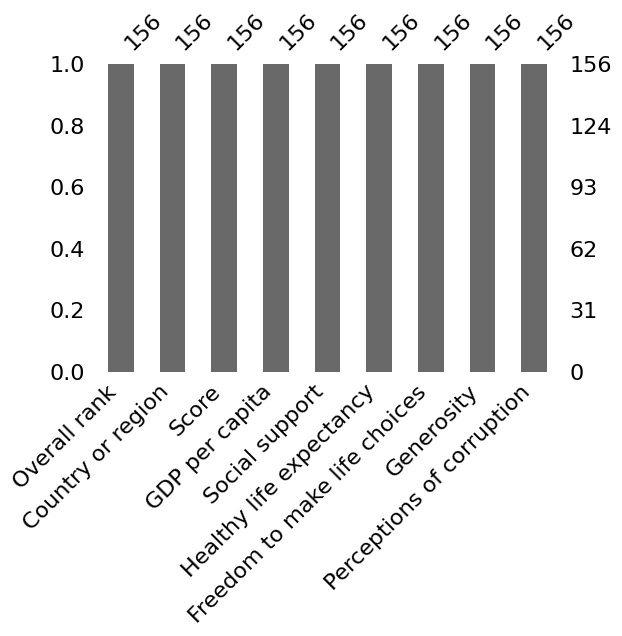

In [16]:
msno.bar(df, figsize=(6,4))

2. Виведіть діаграму розсіювання ознак `Score` та `GDP per capita`, використовуючи метод `regplot()` з `seaborn`.

<Axes: xlabel='GDP per capita', ylabel='Score'>

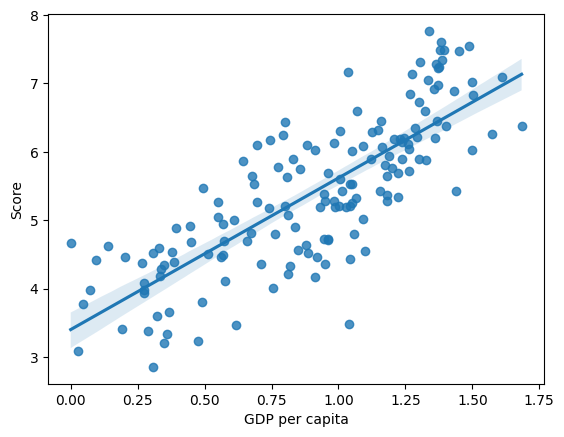

In [17]:
sns.regplot(df, x="GDP per capita", y="Score")

Ми моделюватимемо цю залежність. Тобто незалежною змінною є `GDP per capita`, залежною `Score`. Судячи з діаграми розсіювання, залежність між цими двома змінними має добре описуватись лінійною моделлю.

## Розв'язання задачі лінійної регресії методом градієнтного спуску

Позначення:
- `X` - матриця ознак
- `y` - цільова змінна
- `theta` - вектор параметрів
- `alpha` - темп навчання (learning rate)

<font color='blue'>**[Optional]**</font> 3. Реалізуйте формулу передбачення лінійної регресії у методі `predict`. Метод повертає передбачення. Нагадаю, що для кожного спостереження з матриці ознак передбачення знаходимо за допомогою наступної формули:
$$x \in X, i \in [1,m], j : \\ \hat{y}_i = \theta_0 + \theta_1 x_1 + ... + \theta_n x_n = \theta^T x ,\\
\text{де m - кількість спостережень, } \\ 
\text{n - кількість ознак, } \\
x_0 = 1 \ \text{для всіх спостережень}.
$$

Передбачення всіх спостережень у матриці Х можемо знайти як множення матриці ознак на ваги.

In [18]:
'''
  Expected:
    i in [0, m] ~ rows
    j in [0, n] ~ columns
    X = [m, n], theta = [n, 1]
'''
def add_col_of_1(arr):
  col_1 = np.full((arr.shape[0], 1), 1)
  return np.concatenate((col_1, arr), axis=1)

def predict(X, theta):
    return np.matmul(X, theta)

<font color='blue'>**[Optional]**</font> 4. Доповніть обчислення значення функції витрат, формула якої наведена в слайдах лекції про лінійну регресію (підказка - формула така сама, якби ми рахували середньоквадратичну помилку).  
Метод `cost()` приймає вектор параметрів `theta`, матрицю наших ознак `X` та реальні значення цільової змінної `y`.


In [19]:
def cost(y_true, y_estimate):
    m = len(y_true)
    
    # option 1:
    # Note: 0.5 coefficient 
    cost_value = 0.5*np.average(np.square(y_true - y_estimate))

    # option 2:
    # diff_square = [(y_true[i] - y_estimate[i])**2 for i in range(m)]
    # cost_value = (functools.reduce(lambda a, b: a+b, diff_square) / (2*m))[0]
    
    return cost_value

<font color='blue'>**[Optional]**</font> 5. Ознайомтеся з реалізацією методу `get_gradient()`, який повертає вектор часткових похідних функції витрат за кожним із параметрів лінійної регресії.
Доповніть метод `gradient_descent()`, який дозволить реалізувати алгоритм градієтного спуску. Під час градієнтного спуку ми оновлюємо параметри згідно з формулою:
$$
\text{для кожного} \ j \in [0, n]: \quad \theta_j := \theta_j - \alpha \frac{\partial}{\partial \theta_j}J(\theta), \\ 
\text{де n - кількість ознак}
$$
  Метод градієнтного спуску оновлює ваги (модель навчається) поки вони не перестануть змінюватися від ітерації до ітерації, тобто поки Евклідова відстань (звичайна відстань між веткорами, як у шкільній геометрії) між векторами ваг за останні дві ітерації не буде меншою за невелику константу (зазвичай позначається як $\epsilon$ (епсілон), ми встановимо $\epsilon=10^{-6}$).

В `gradient_descent()` заповніть всі місця, де стоять три крапки. Використовуйте реалізовані у попередніх завданнях методи `cost()` та `predict()`, і звичайно ж Вам знадобиться метод `get_gradient()`.

In [20]:
def get_gradient(X, y, y_estimate):
    gradient = [np.matmul((y_estimate - y).T, X[:,j]) for j in range(X.shape[1])]
    return np.asarray(gradient)

In [22]:
def gradient_descent(X, y, theta, learning_rate, eps, max_iterations):
    cost_history = []
    theta_history = []
    iterations = 0

    y_estimate = predict(X, theta)                 # передбачення з поточними значеннями вагів

    while True:
        cost_value = cost(y, y_estimate)           # значення функції витрат при поточних вагах
        cost_history.append(cost_value)

        gradient = get_gradient(X, y, y_estimate)  # значення часткових похідних функції витрат з поточними значеннями ваг
        new_theta = theta - learning_rate*gradient
        theta_history.append(new_theta)

        # Умова зупинки, описана в умові завдання
        y_estimate = predict(X, new_theta)
        distance = np.sqrt(np.sum(np.square(y - y_estimate)))
 
        if distance < eps:
            print("Алгоритм зійшовся.")
            break
            
        # Друга умова зупинки
        if iterations >= max_iterations:
            print("Досягнуто максимальної кількості ітерацій")
            break

        # Виводимо інформацію кожні 100 ітерацій
        if iterations % 100 == 0:
            print ("Ітерація: %d - Помилка на трейн даних: %.4f" % (iterations, cost_value))

        iterations += 1
        theta = new_theta

    return theta, cost_history, theta_history, iterations

Підготуємо дані.

In [23]:
X = df['GDP per capita'].values.reshape(-1,1)
y = df['Score'].values.reshape(-1,1)

6. Розділіть `X` та `y` на `train` і `test` підвиборки у співвідношенні 80/20. Оскільки у нас мало даних, валідаційну вибірку не виділятимемо. Запишіть результати у `X_train`, `y_train`, `X_test`, `y_test`.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

7.Реалізуйте масштабування ознак із використанням `MinMaxScaler`. Пам'ятайте про те, як ми застосовуємо масштабування ознак на`train` та `test` вибірках.

In [27]:
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
min_max_scaler.fit(X_train)
X_train_scaled = min_max_scaler.transform(X_train)
X_test_scaled = min_max_scaler.transform(X_test)

<font color='blue'>**[Optional]**</font> 8. Додайте колонку з одиниць до масивів `X_train`, `X_test`.

In [28]:
X_train_full = add_col_of_1(X_train_scaled)
X_test_full = add_col_of_1(X_test_scaled)

<font color='blue'>**[Optional]**</font> 9. Встановіть темп навчання рівний 0.01, точність епсілон рівний $10^{-6}$, кількість ітерацій дорівнює 20000 і запустіть градієнтний спуск на тренувальні дані, передавши всі необхідні параметри.

In [29]:
# on features without scaling 0.01 gives to big steps and algorithm will fail
learning_rate = 0.01
max_iterations = 20000
epsilon = 1e-6

theta = np.random.randn(2,1)
print(theta)

theta, cost_history, theta_history, iterations = gradient_descent(X_train_full, y_train, theta, learning_rate, epsilon, max_iterations)

[[ 1.2281546 ]
 [-0.36258906]]
Ітерація: 0 - Помилка на трейн даних: 10.2275
Ітерація: 100 - Помилка на трейн даних: 0.2209
Ітерація: 200 - Помилка на трейн даних: 0.2209
Ітерація: 300 - Помилка на трейн даних: 0.2209
Ітерація: 400 - Помилка на трейн даних: 0.2209
Ітерація: 500 - Помилка на трейн даних: 0.2209
Ітерація: 600 - Помилка на трейн даних: 0.2209
Ітерація: 700 - Помилка на трейн даних: 0.2209
Ітерація: 800 - Помилка на трейн даних: 0.2209
Ітерація: 900 - Помилка на трейн даних: 0.2209
Ітерація: 1000 - Помилка на трейн даних: 0.2209
Ітерація: 1100 - Помилка на трейн даних: 0.2209
Ітерація: 1200 - Помилка на трейн даних: 0.2209
Ітерація: 1300 - Помилка на трейн даних: 0.2209
Ітерація: 1400 - Помилка на трейн даних: 0.2209
Ітерація: 1500 - Помилка на трейн даних: 0.2209
Ітерація: 1600 - Помилка на трейн даних: 0.2209
Ітерація: 1700 - Помилка на трейн даних: 0.2209
Ітерація: 1800 - Помилка на трейн даних: 0.2209
Ітерація: 1900 - Помилка на трейн даних: 0.2209
Ітерація: 2000 - Пом

<font color='blue'>**[Optional]**</font> 10. Відобразіть на лінійному графіку значення змінної `cost_history`. Використовуйте будь-яку бібліотеку для візуалізації на вибір.

<Axes: >

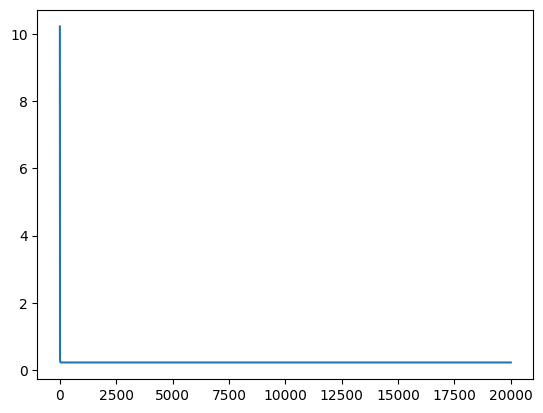

In [31]:
type(cost_history)
sns.lineplot(data=cost_history)

Відобразіть лише перші 200 ітерацій. Схоже, що після них модель мало навчається. Ми могли б застосувати техніку early stopping у даному випадку та зупинитися на деякій невеликій кількості ітерацій. Зазвичай ця техніка застосовується, щоб уникнути перенавчання. При цьому втрачається трохи точності на train set.

<Axes: >

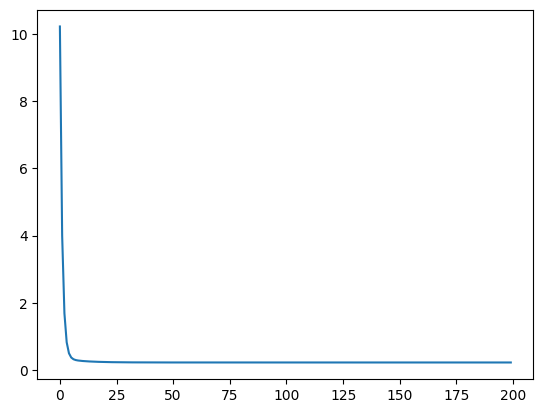

In [33]:
sns.lineplot(data=cost_history[:200])

Виведемо отримані параметри та останнє значення функції витрат.

In [34]:
print('Theta0:          {:0.3f},\nTheta1:          {:0.3f}'.format(theta[0][-1],theta[1][-1]))
print('Final cost/MSE:  {:0.3f}'.format(cost_history[-1]))
print('Number of iterateions: {:d}'.format(iterations))

Theta0:          3.421,
Theta1:          3.710
Final cost/MSE:  0.221
Number of iterateions: 20000


<font color='blue'>**[Optional]**</font> 11. Знайдіть прогнози на `X_train`, `X_test` та порахуйте `mean_squared_error` помилку прогнозів обох підвибірках.

In [35]:
def get_metrics(y_true, y_predicted, n_digits=5):
    params = dict(y_true=y_true, y_pred=y_predicted)
    mse = mean_squared_error(**params)
    rmse = mean_squared_error(**params, squared=False)
    return dict(mse=round(mse, n_digits), rmse=round(rmse, n_digits))

y_train_pred = predict(X_train_full, theta)
y_test_pred = predict(X_test_full, theta)

train_metrics = get_metrics(y_train, y_train_pred)
test_metrics = get_metrics(y_test, y_test_pred)

dict(train=train_metrics, test=test_metrics)

{'train': {'mse': 0.44172, 'rmse': 0.66462},
 'test': {'mse': 0.50791, 'rmse': 0.71268}}

<font color='blue'>**[Optional]**</font> 12. Виведіть діаграму розсіювання ознак `Score` та `GDP per capita` та додайте лінію прогнозу моделі.

<Axes: xlabel='GDP per capita', ylabel='Score'>

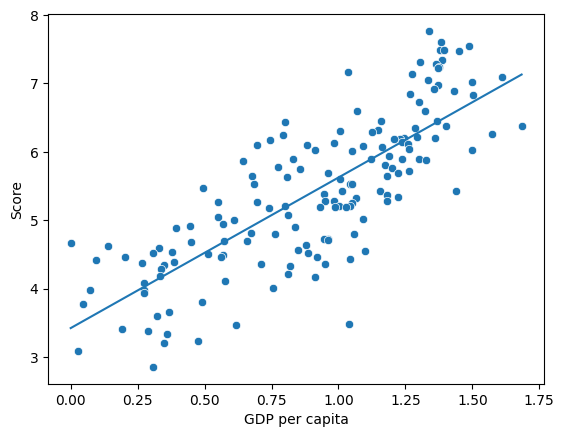

In [52]:
sns.scatterplot(df, x="GDP per capita", y="Score")
# 2 points is enough to build regression line
# will use min and max of "GDP per capita" for good align on plot with whole dataset
x_min_max = np.asarray([[df["GDP per capita"].min()], [df["GDP per capita"].max()]])
x_ = min_max_scaler.transform(x_min_max)

x_ = add_col_of_1(x_)
y_ = predict(x_, theta)

sns.lineplot(x=x_min_max.flatten(), y=y_.flatten())

13. Навчіть лінійну регресію на наборі даних, що складається тільки з ознаки `GDP per capita`, але тепер використовуючи LinearRegression з sklearn.   
Подумайте, чи треба в sklearn модель подавати стовпчик з одиниць, яку ми подавали в самописну модель.

In [53]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
LinearRegression()
lr.coef_, lr.intercept_

(array([[3.7098397]]), array([3.42116754]))

Порівняйте помилку на тестовій вибірці лінійної регресії, написаної вами, та зі sklearn. Чи є різниця у значеннях?

In [54]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_metrics = get_metrics(y_train, y_train_pred)
    test_metrics = get_metrics(y_test, y_test_pred)

    return dict(train=train_metrics, test=test_metrics)

In [56]:
evaluate_model(lr, X_train_scaled, X_test_scaled, y_train, y_test)

{'train': {'mse': 0.44172, 'rmse': 0.66462},
 'test': {'mse': 0.50791, 'rmse': 0.71268}}

As we see values are indetical for sklearn and handwritten calculation

14. Навчимо лінійну регресію на більшій кількості ознак і подивимося, чи вдасться покращити модель.

14.1 Навчіть лінійну регресію з sklearn використовуючи як набор ознак наступний: `GDP per capita`, `Social support`, `Healthy life expectancy`, `Freedom to make life choices`, `Generosity`, `Perceptions of corruption`

Не забудьте:  
1. Розділити `train` та `test`.
2. Нормувати кожну колонку даних. 

In [58]:
y_col_name = "Score"
x_cols_name = [
    "GDP per capita",
    "Social support",
    "Healthy life expectancy",
    "Freedom to make life choices",
    "Generosity",
    "Perceptions of corruption"
]

X = df[x_cols_name]
y = df[y_col_name]

train_id, test_id = train_test_split(X.index, test_size=0.2, shuffle=True, random_state=42)
print(len(train_id), len(test_id)) 

124 32


In [59]:
# feature scaling
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
min_max_scaler.fit(X.loc[train_id])
min_max_scaled = min_max_scaler.transform(X)
min_max_scaled_df = pd.DataFrame(min_max_scaled, columns=X.columns)
min_max_scaled_df[:5]

,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,0.795724,0.977217,0.864154,0.944532,0.270318,0.867550
1,0.821259,0.968596,0.872918,0.938193,0.445230,0.905077
2,0.883610,0.974138,0.900964,0.955626,0.478799,0.752759
3,0.819477,1.000000,0.899211,0.936609,0.625442,0.260486
4,0.828979,0.937192,0.875548,0.882726,0.568905,0.657837


In [60]:
lr = LinearRegression()
lr.fit(min_max_scaled_df.loc[train_id], y.loc[train_id])
lr.coef_, lr.intercept_

(array([1.26420675, 2.00129534, 1.06220807, 0.94007222, 0.15303419,
        0.50393133]),
 1.8115122981234268)

14.2 Виведіть помилку прогнозу на `train` та `test` вибірках. Порівняйте з результатом, отриманим під час навчання однією ознакою. Чи змінилися метрики?

In [61]:
evaluate_model(lr, min_max_scaled_df.loc[train_id], min_max_scaled_df.loc[test_id], y.loc[train_id], y.loc[test_id])

{'train': {'mse': 0.23647, 'rmse': 0.48628},
 'test': {'mse': 0.41446, 'rmse': 0.64379}}

Well, all metrics are better, but difference between test and train are bigger

14.3 Виведіть коефіцієнти моделі і визначте, які ознаки мають найбільші коефіцієнти по модулю, що стоять перед ними (достатньо вивести назви ознак і коефіцієнти в одному датафреймі).

In [62]:
pd.DataFrame(np.abs(lr.coef_), index=x_cols_name, columns=["coef"]).sort_values("coef", ascending=False)

,coef
Social support,2.001295
GDP per capita,1.264207
Healthy life expectancy,1.062208
Freedom to make life choices,0.940072
Perceptions of corruption,0.503931
Generosity,0.153034


"Social support", "GDP per capita"

15. Навчіть модель поліноміальної регресії зі ступенем 2 на тих самих даних, що й у попередньому пункті. Використовуйте у процесі навчання `PolynomialFeatures`. Дослідіть метрики якості на трейні та тест датасетах. Чи є перенавчання (overfit)?

In [142]:
poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X.loc[train_id])
X_test_poly = poly_features.transform(X.loc[test_id])

poly_model = LinearRegression()
poly_model.fit(X_train_poly, y.loc[train_id])

evaluate_model(poly_model, X_train_poly, X_test_poly, y.loc[train_id], y.loc[test_id])

{'train': {'mse': 0.18086, 'rmse': 0.42528},
 'test': {'mse': 0.42258, 'rmse': 0.65006}}

Results are better for train set and much worse for test => we have overfit

16. Зробіть пайплайн із кроками `MinMaxScaler`, `PolynomialFeatures` та `ElasticNet`. 

Яка модель у домашньому завданні дала найкращі значення середньоквадратичної помилки на тестових даних, лін. регресія написана самостійно, лін. регресія зі sklearn, поліноміальна регресія?

In [147]:
pipe = Pipeline([
    ("scale_min_max", MinMaxScaler(feature_range=(0, 1))),
    ("polynomial_features", PolynomialFeatures(degree=2)),
    ("elastic_net", ElasticNet(alpha=0.5))
    ])

pipe.fit(X.loc[train_id], y.loc[train_id])

evaluate_model(pipe, X.loc[train_id], X.loc[test_id], y.loc[train_id], y.loc[test_id])

{'train': {'mse': 1.27946, 'rmse': 1.13113},
 'test': {'mse': 1.04443, 'rmse': 1.02197}}

Linier regression with multiple features has best precision on test data overall, but has bigger difference between test and train presicion than liner regression with only "GDP per capita" feature. I think playing with feature set can give better results